# Jakub Grzyb GGSN 2025 grupa 1

[https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

# Imports

In [1]:
import torch
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from itertools import product

from concurrent.futures import ThreadPoolExecutor

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torch import tensor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Training prep and augumentation

augumentation is time consuming so I created augumented set 10x larger than original

In [2]:
if not os.path.exists("data"):
    for folder in ["data/NORMAL", "data/PNEUMONIA"]:
        if os.path.exists(folder):
            for file in os.listdir(folder):
                file_path = os.path.join(folder, file)
                if os.path.isfile(file_path):
                    os.remove(file_path)

    augmentation_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), fill=0, scale=(0.8, 1.2)),
    ])

    train_dataset = datasets.ImageFolder(root='chest_xray/train', transform=augmentation_transform)

    class_counts = np.bincount(train_dataset.targets)
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[train_dataset.targets]
    sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, sampler=sampler)

    counter = 0
    def save_image(image, label, counter):
        label_folder = "data/NORMAL" if label == 0 else "data/PNEUMONIA"
        os.makedirs(label_folder, exist_ok=True)
        image_path = os.path.join(label_folder, f"image_{counter}.png")
        image = transforms.ToPILImage()(image.cpu())
        image.save(image_path)

    with ThreadPoolExecutor() as executor:
        futures = []
        for i in range(9):
            for images, labels in train_loader:
                for img, lbl in zip(images, labels):
                    futures.append(executor.submit(save_image, img, lbl.item(), counter))
                    counter += 1
                print(".", end="")
        for future in futures:
            future.result()  # Ensure all tasks are completed
        print(f"\nProcessed {counter} images")

# Helpers

In [3]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [4]:
def plot_first_layer(layer, loader):
    for images, labels in loader:
        for image, label in zip(images, labels):
            image = image.unsqueeze(0).to(device)
            output = layer(image)
            output = output.squeeze().cpu().detach().numpy()
            break
        break

    fig, axes = plt.subplots(4, output.shape[0]//4, figsize=(20, 10))
    fig.suptitle("Output Channels", fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < output.shape[0]:
            ax.imshow(output[i], cmap='viridis')
            ax.axis('off')
            ax.set_title(f"Channel {i+1}")
    plt.tight_layout()
    plt.show()

In [5]:
def plot_heat_map(model, loader):
    for images, labels in loader:
        for image, label in zip(images, labels):
            image = image.unsqueeze(0).to(device)
            break
        break

    model.eval()
    image.unsqueeze(0).to(device)
    image.requires_grad = True

    output = model(image)
    target_score = output.squeeze()

    model.zero_grad()
    target_score.backward()

    saliency = image.grad.data.abs().squeeze().cpu().numpy()

    if saliency.ndim == 3:
        saliency = np.max(saliency, axis=0)

    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image.squeeze().permute(1, 2, 0).mean(dim=-1).cpu().detach().numpy(), cmap='viridis')
    ax[0].axis('off')
    ax[0].set_title(f"Original Image, label: {label}")

    ax[1].imshow(saliency, cmap='hot')
    ax[1].axis('off')
    ax[1].set_title(f"Saliency Map (Heatmap), label: {output.item():.2f}")

    plt.show()

# Data

### Transform

In [6]:
data_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [7]:
augmentation_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.1, 0.1), fill=0, scale=(0.8, 1.2)),
])

In [8]:
tmp_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [9]:
train_dataset = datasets.ImageFolder(root='data', transform=tmp_transform)
# train_dataset = datasets.ImageFolder(root='chest_xray/train', transform=augmentation_transform)
val_dataset = datasets.ImageFolder(root='chest_xray/val', transform=data_transform)
test_dataset = datasets.ImageFolder(root='chest_xray/test', transform=data_transform)

In [10]:
class_counts = np.bincount(train_dataset.targets)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_dataset.targets]
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

### DataLoader

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

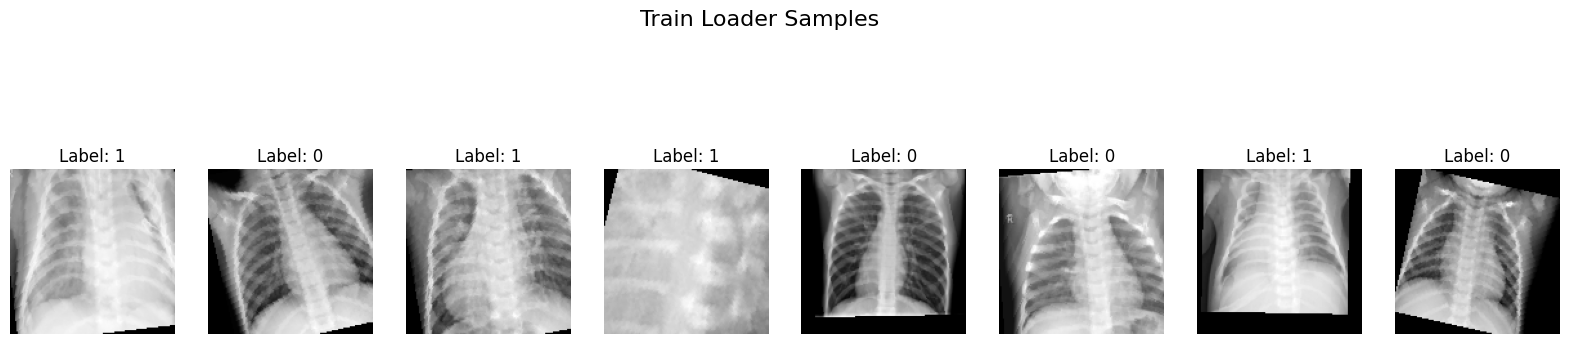

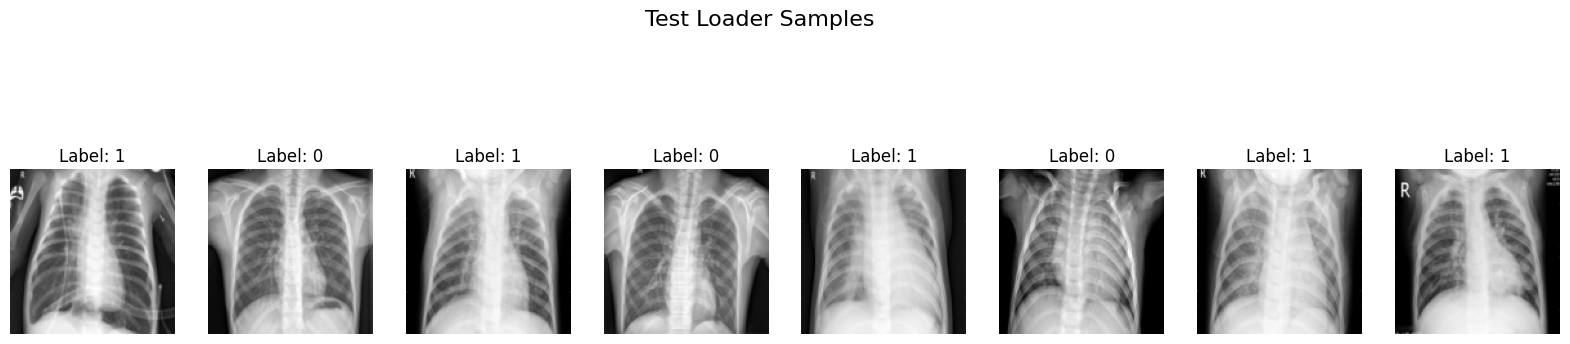

In [12]:
# Corrected show_samples function
def show_samples(loader, title):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, 8, figsize=(20, 5))
    fig.suptitle(title, fontsize=16)
    for i in range(8):
        ax = axes[i]
        # Convert from (C, H, W) to (H, W, C) for imshow
        img = images[i].permute(1, 2, 0).numpy()
        # Normalize to [0, 1] for display if necessary
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {labels[i].item()}")

# Show samples from train_loader
show_samples(train_loader, "Train Loader Samples")

# Show samples from test_loader
show_samples(test_loader, "Test Loader Samples")

# Training

In [13]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_accuracy = 0.0
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, val_accuracy, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_accuracy = val_accuracy
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [15]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=5):
    model.to(device)
    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_labels = []
        running_preds = []
        progress = -1
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            running_labels.extend(labels.cpu().numpy())
            running_preds.extend((outputs.squeeze() > 0.5).cpu().numpy())

            new_progress = i * 10 // len(train_loader)
            if new_progress > progress:
                val_loss = 0.0
                val_labels = []
                val_preds = []
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device).float()
                        outputs = model(images)
                        loss = criterion(outputs.squeeze(), labels)
                        val_loss += loss.item()

                        val_labels.extend(labels.cpu().numpy())
                        val_preds.extend((outputs.squeeze() > 0.5).cpu().numpy())

                train_loss = running_loss / len(train_loader)
                val_loss = val_loss / len(val_loader)
                train_accuracy = accuracy_score(running_labels, running_preds) * 100
                val_accuracy = accuracy_score(val_labels, val_preds) * 100

                history['train_loss'].append(train_loss)
                history['val_loss'].append(val_loss)
                history['train_accuracy'].append(train_accuracy)
                history['val_accuracy'].append(val_accuracy)

                print(f"Epoch [{epoch*10 + progress + 1}/{num_epochs*10}],   "
                    f"Train Loss: {train_loss:.4f},   "
                    f"Train Accuracy: {train_accuracy:.2f}%,        "
                    f"Val Loss: {val_loss:.4f},   "
                    f"Val Accuracy: {val_accuracy:.2f}%")
                
                progress = new_progress
                
                early_stopping(val_loss / len(val_loader), accuracy_score(val_labels, val_preds) * 100, model)
                if early_stopping.early_stop:
                    break

        if early_stopping.early_stop:
            model.load_state_dict(early_stopping.best_model)
            print("Early stopping")
            print(f"Best Validation Accuracy: {early_stopping.best_accuracy:.2f}%")
            print(f"Best Validation Loss: {early_stopping.best_loss:.4f}")
            break

    return history

In [16]:
def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), tensor(labels).to(device).float()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend((outputs.squeeze() > 0.5).cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(all_labels, all_preds) * 100
    return val_loss, val_accuracy

# Simple Model

### Model

In [17]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.norm1 = torch.nn.BatchNorm2d(16)
        self.drop1 = torch.nn.Dropout(0.2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.norm2 = torch.nn.BatchNorm2d(32)
        self.drop2 = torch.nn.Dropout(0.2)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = torch.nn.ReLU()
        self.norm3 = torch.nn.BatchNorm2d(64)
        self.drop3 = torch.nn.Dropout(0.2)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.flat = torch.nn.Flatten()
        self.dense = torch.nn.Linear(64 * 16 * 16, 128)
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(0.3)
        self.out = torch.nn.Linear(128, 1)
        self.output = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.pool1(self.drop1(self.norm1(self.relu1(self.conv1(x)))))
        x = self.pool2(self.drop2(self.norm2(self.relu2(self.conv2(x)))))
        x = self.pool3(self.drop3(self.norm3(self.relu3(self.conv3(x)))))
        x = self.flat(x)
        x = self.drop(self.relu(self.dense(x)))
        x = self.out(x)
        x = self.output(x)
        return x

### Training

In [18]:
model = SimpleCNN().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
history = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=10)

Epoch [0/100],   Train Loss: 0.0004,   Train Accuracy: 59.38%,        Val Loss: 3.0984,   Val Accuracy: 50.00%
Epoch [1/100],   Train Loss: 0.0548,   Train Accuracy: 79.07%,        Val Loss: 1.0207,   Val Accuracy: 56.25%
Epoch [2/100],   Train Loss: 0.0847,   Train Accuracy: 83.52%,        Val Loss: 1.2396,   Val Accuracy: 62.50%
Epoch [3/100],   Train Loss: 0.1126,   Train Accuracy: 85.43%,        Val Loss: 0.7430,   Val Accuracy: 68.75%
Epoch [4/100],   Train Loss: 0.1374,   Train Accuracy: 86.67%,        Val Loss: 0.8859,   Val Accuracy: 56.25%
Epoch [5/100],   Train Loss: 0.1613,   Train Accuracy: 87.53%,        Val Loss: 1.1452,   Val Accuracy: 56.25%
Epoch [6/100],   Train Loss: 0.1831,   Train Accuracy: 88.21%,        Val Loss: 1.1133,   Val Accuracy: 62.50%
Epoch [7/100],   Train Loss: 0.2031,   Train Accuracy: 88.86%,        Val Loss: 0.7811,   Val Accuracy: 56.25%
Epoch [8/100],   Train Loss: 0.2225,   Train Accuracy: 89.33%,        Val Loss: 1.0486,   Val Accuracy: 56.25%
E

### Visualisations

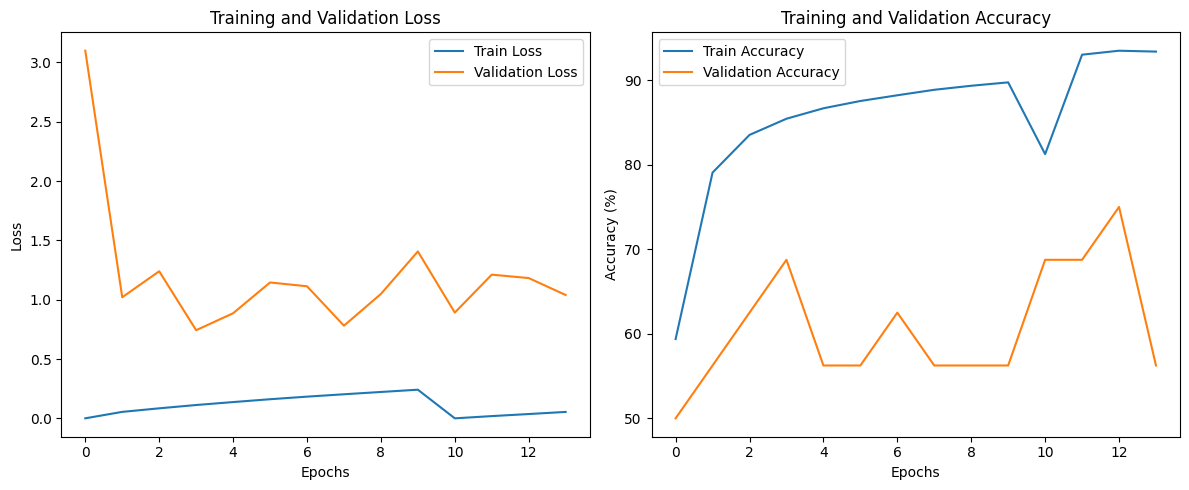

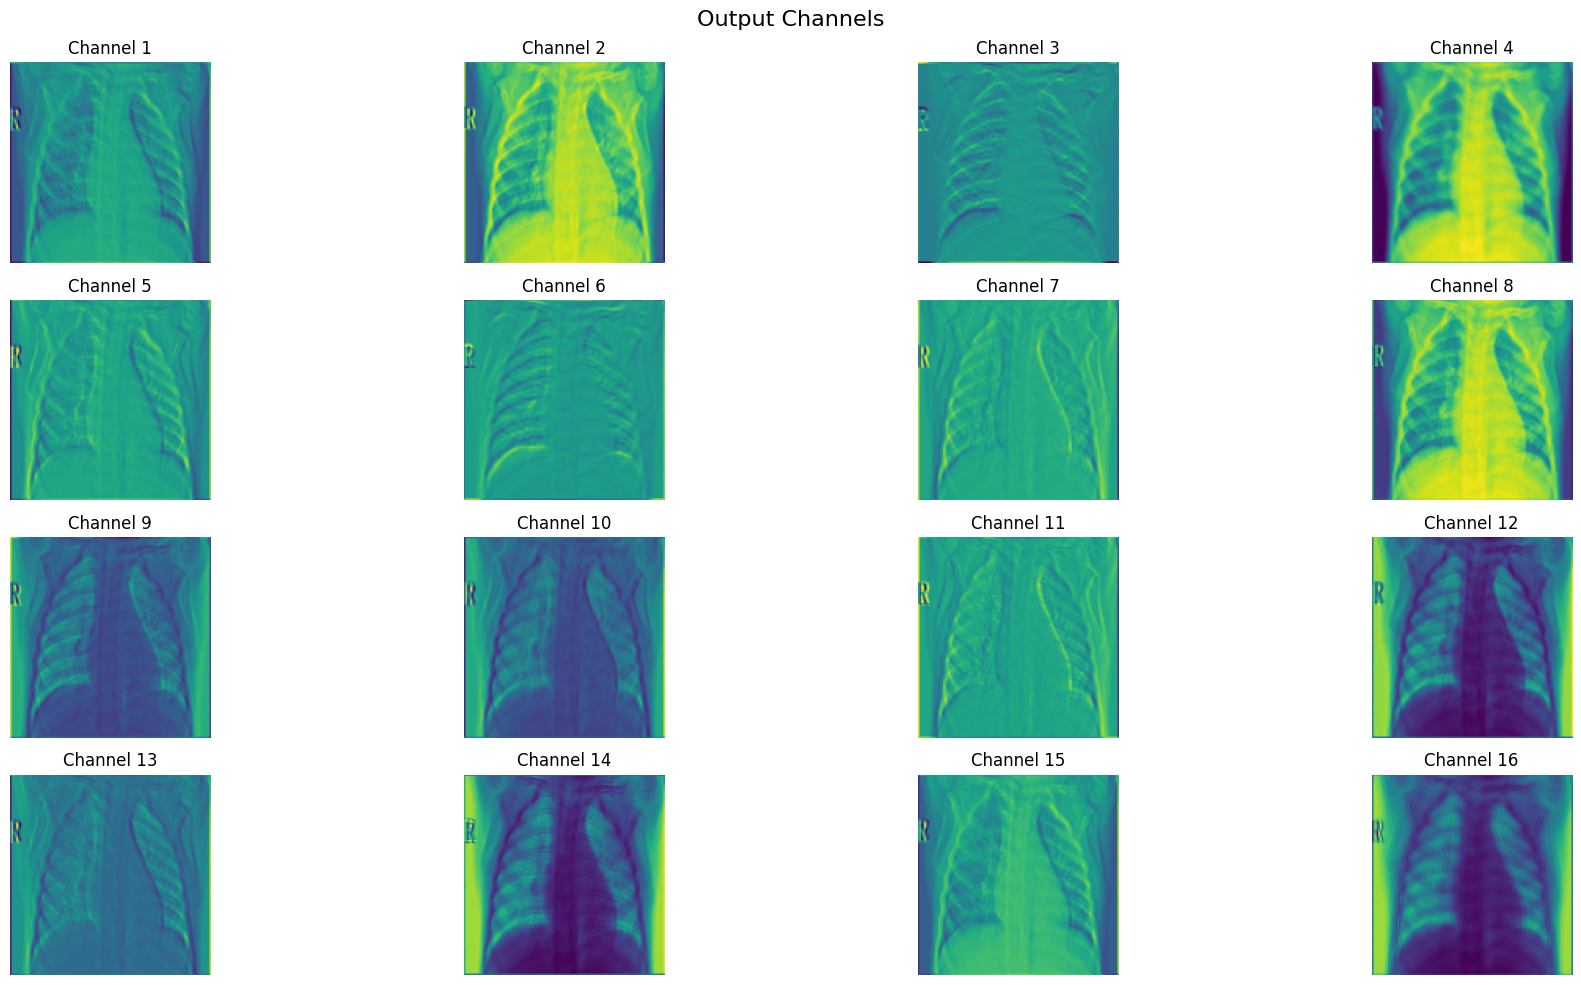

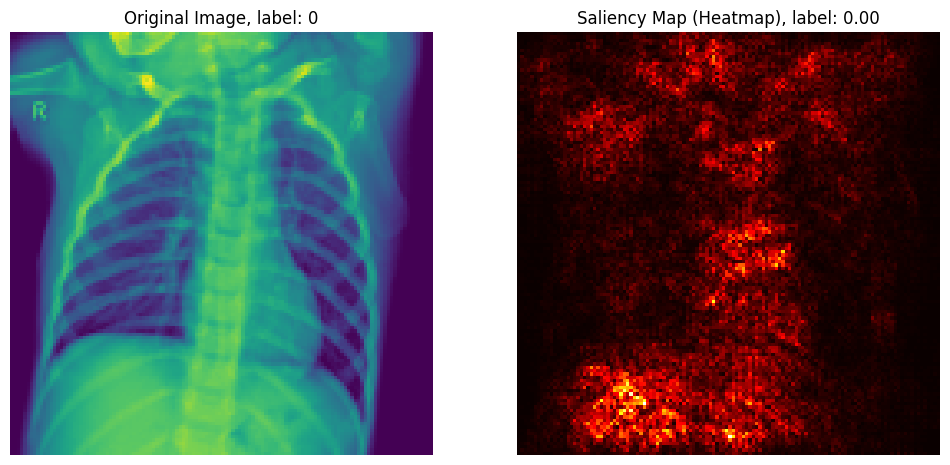

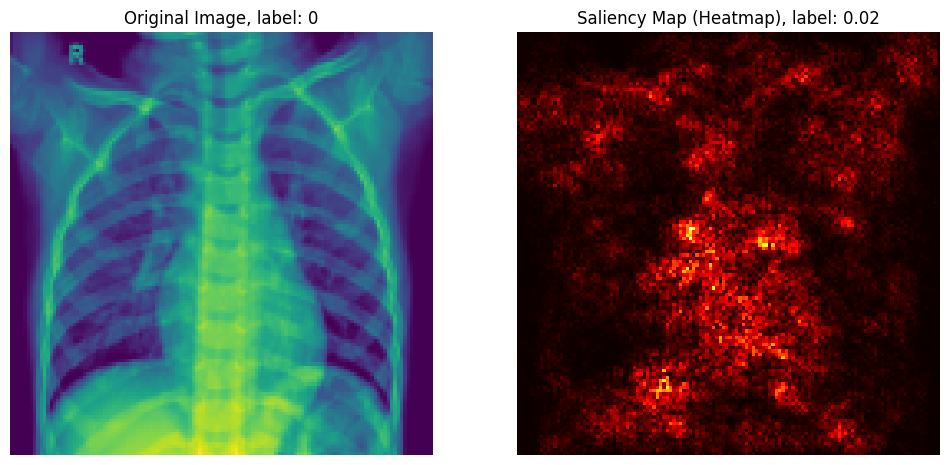

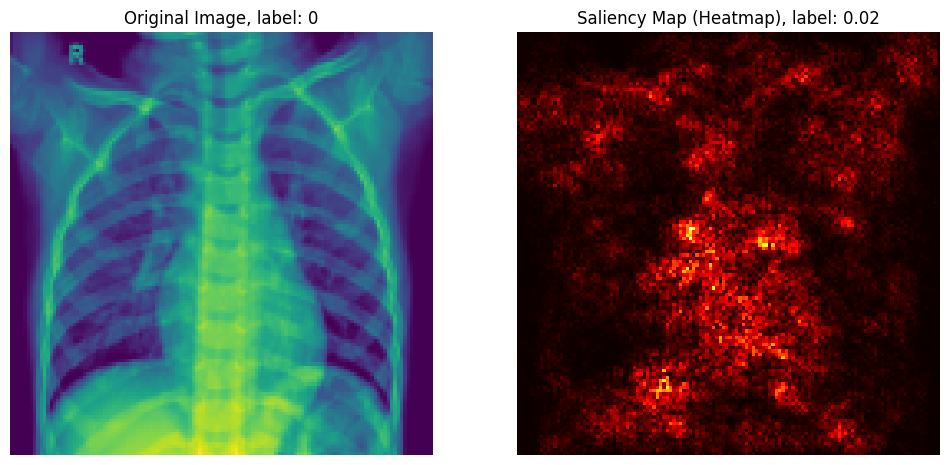

In [20]:
plot_history(history)
plot_first_layer(model.conv1, val_loader)
for _ in range(3):
    plot_heat_map(model, val_loader)

### Tuning

In [21]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.Dropout(0.5),

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.5),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout(0.5),

    nn.Flatten(),
    nn.Linear(64 * 32 * 32, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

### Training

In [22]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [23]:
history = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=10)

Epoch [0/100],   Train Loss: 0.0005,   Train Accuracy: 53.12%,        Val Loss: 0.7147,   Val Accuracy: 62.50%
Epoch [1/100],   Train Loss: 0.0491,   Train Accuracy: 76.58%,        Val Loss: 0.8134,   Val Accuracy: 56.25%
Epoch [2/100],   Train Loss: 0.0880,   Train Accuracy: 79.91%,        Val Loss: 0.9738,   Val Accuracy: 50.00%
Epoch [3/100],   Train Loss: 0.1216,   Train Accuracy: 81.77%,        Val Loss: 0.6117,   Val Accuracy: 81.25%
Epoch [4/100],   Train Loss: 0.1524,   Train Accuracy: 83.15%,        Val Loss: 0.6270,   Val Accuracy: 75.00%
Epoch [5/100],   Train Loss: 0.1795,   Train Accuracy: 84.46%,        Val Loss: 0.8369,   Val Accuracy: 75.00%
Epoch [6/100],   Train Loss: 0.2064,   Train Accuracy: 85.27%,        Val Loss: 0.6507,   Val Accuracy: 81.25%
Epoch [7/100],   Train Loss: 0.2307,   Train Accuracy: 86.01%,        Val Loss: 0.6136,   Val Accuracy: 62.50%
Epoch [8/100],   Train Loss: 0.2556,   Train Accuracy: 86.52%,        Val Loss: 0.6734,   Val Accuracy: 75.00%
E

### Visualization

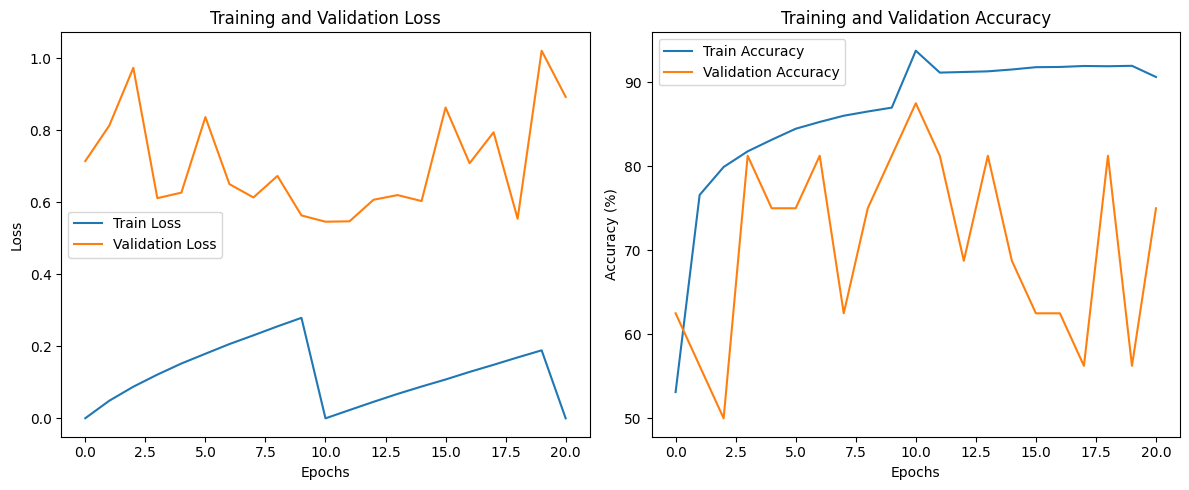

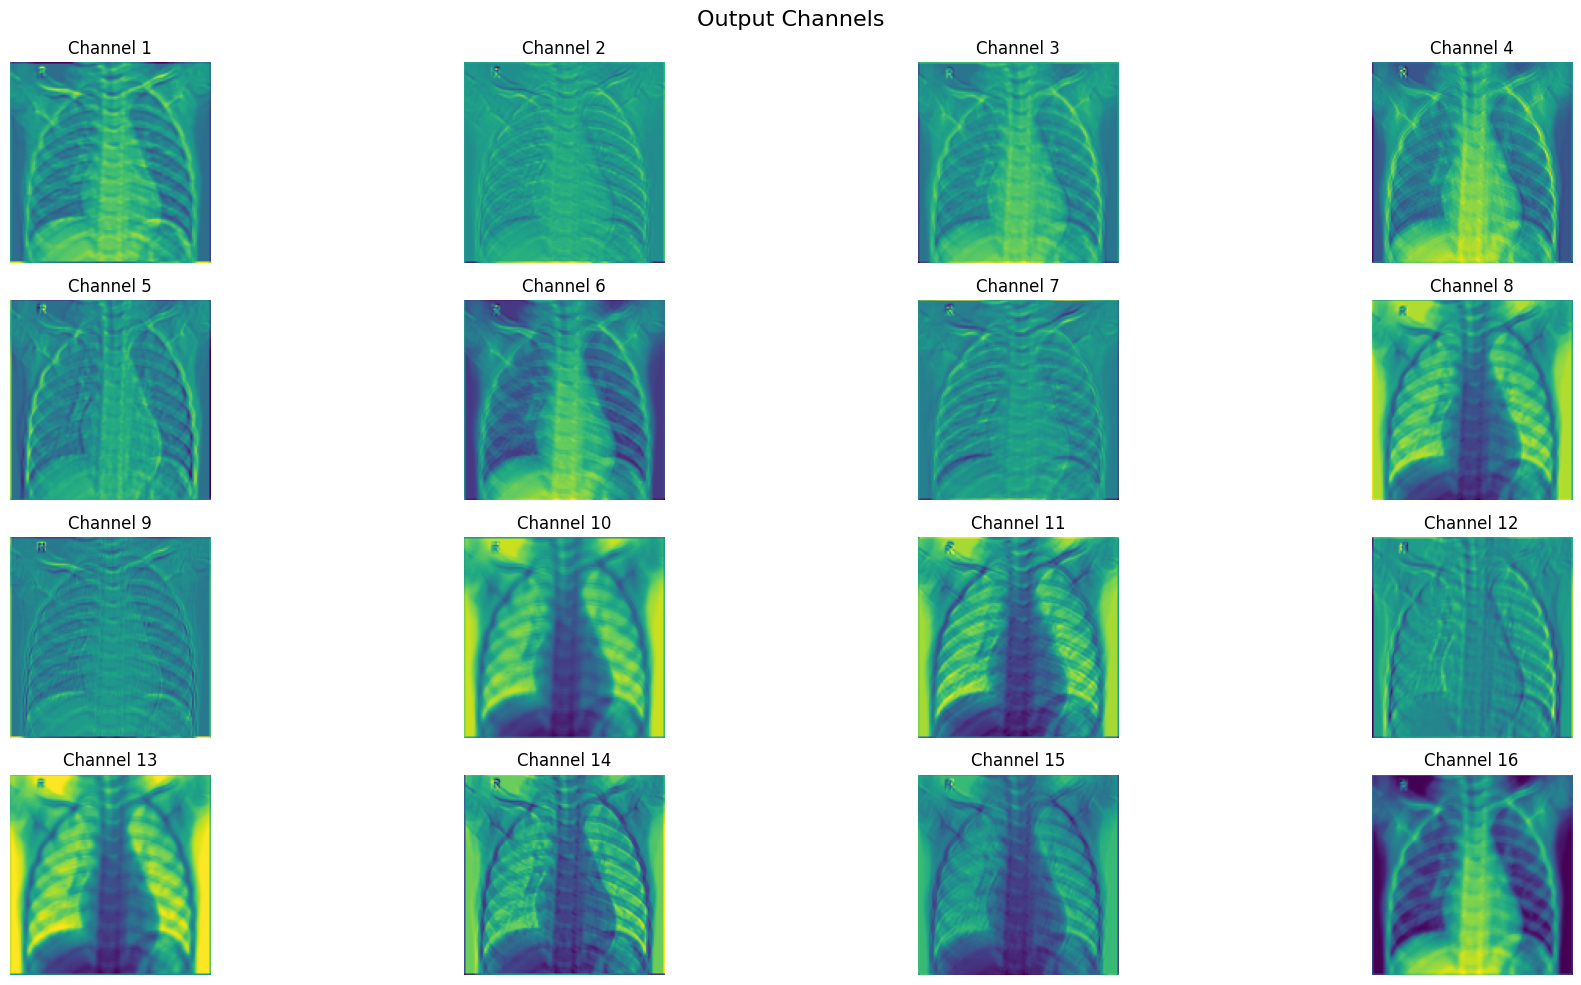

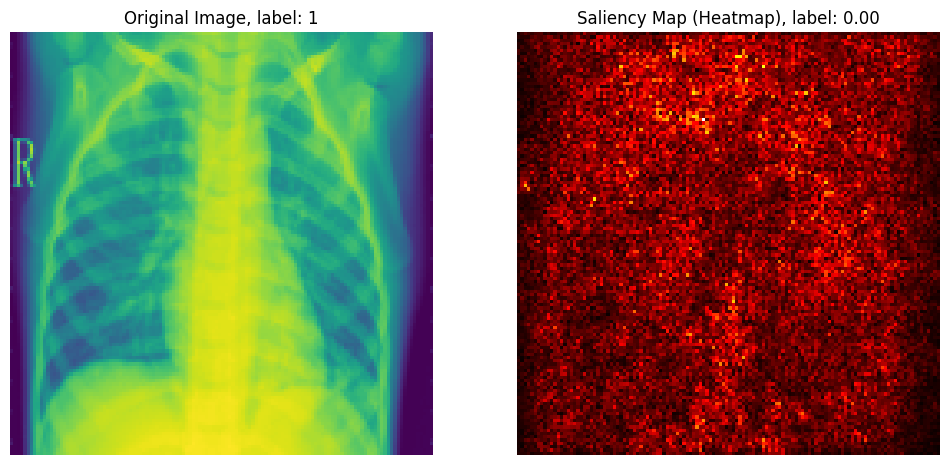

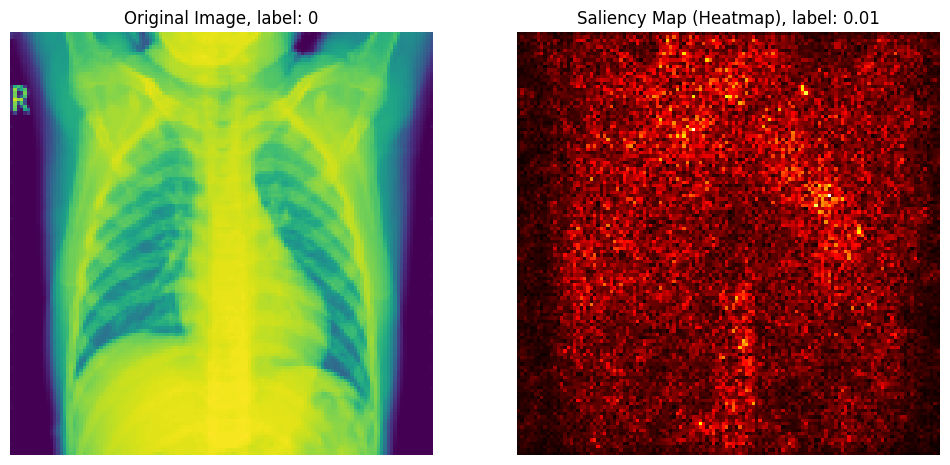

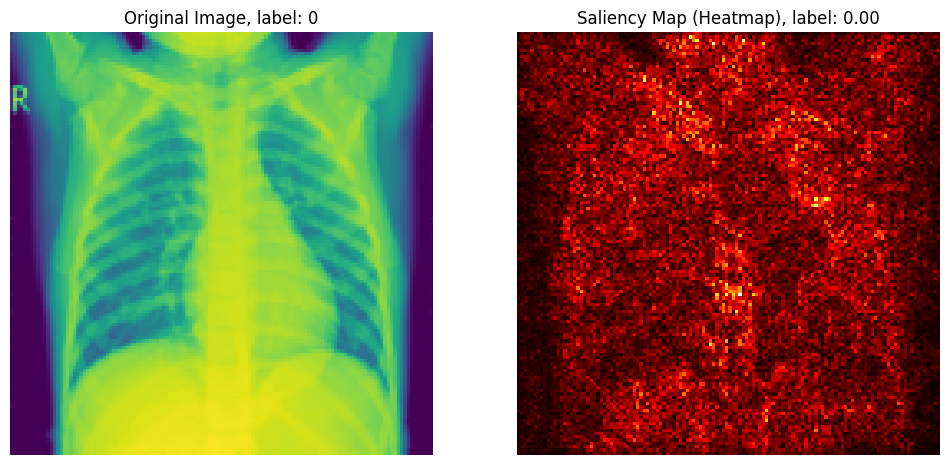

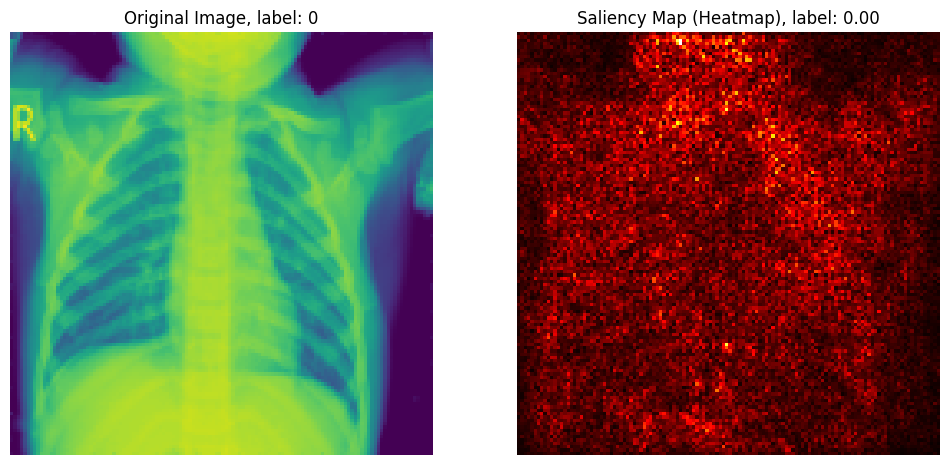

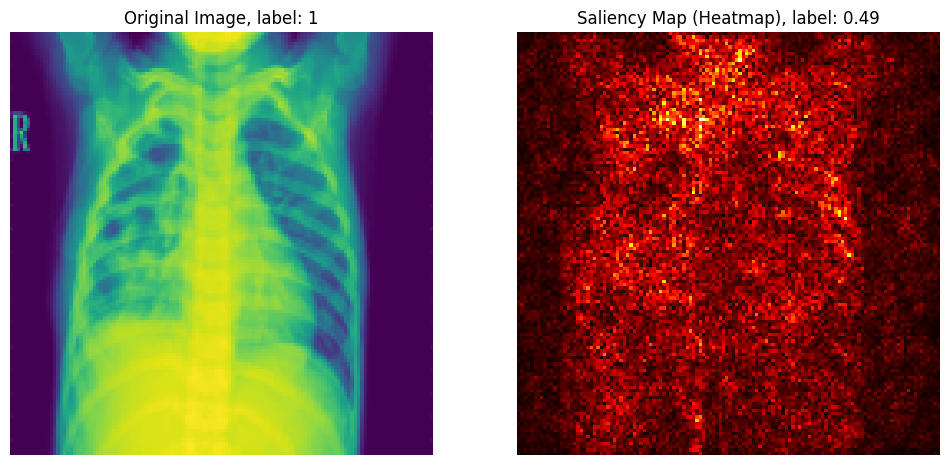

In [24]:
plot_history(history)
plot_first_layer(model[0], val_loader)
for _ in range(5):
    plot_heat_map(model, val_loader)

# Transfer learning

### Model

In [25]:
def create_transfer_learning_model(model: nn.Module, dropout: float = 0.2, last_layer_size: int = 128):
    if isinstance(model, models.MobileNetV2):
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier = nn.Sequential(
            nn.Linear(model.last_channel, last_layer_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(last_layer_size, 1)
        )
    elif isinstance(model, models.ResNet):
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, last_layer_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(last_layer_size, 1)
        )

    return model

### Training

In [26]:
model = create_transfer_learning_model(models.mobilenet_v2(
    weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [27]:
history = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=10)

Epoch [0/100],   Train Loss: 0.0005,   Train Accuracy: 37.50%,        Val Loss: 0.6924,   Val Accuracy: 50.00%
Epoch [1/100],   Train Loss: 0.0530,   Train Accuracy: 69.31%,        Val Loss: 0.5161,   Val Accuracy: 87.50%
Epoch [2/100],   Train Loss: 0.0916,   Train Accuracy: 76.00%,        Val Loss: 0.4660,   Val Accuracy: 87.50%
Epoch [3/100],   Train Loss: 0.1259,   Train Accuracy: 78.98%,        Val Loss: 0.4473,   Val Accuracy: 93.75%
Epoch [4/100],   Train Loss: 0.1585,   Train Accuracy: 80.62%,        Val Loss: 0.3935,   Val Accuracy: 93.75%
Epoch [5/100],   Train Loss: 0.1908,   Train Accuracy: 81.80%,        Val Loss: 0.4020,   Val Accuracy: 93.75%
Epoch [6/100],   Train Loss: 0.2206,   Train Accuracy: 82.66%,        Val Loss: 0.4030,   Val Accuracy: 93.75%
Epoch [7/100],   Train Loss: 0.2503,   Train Accuracy: 83.37%,        Val Loss: 0.3927,   Val Accuracy: 93.75%
Epoch [8/100],   Train Loss: 0.2794,   Train Accuracy: 83.90%,        Val Loss: 0.3552,   Val Accuracy: 93.75%
E

### Visualizations

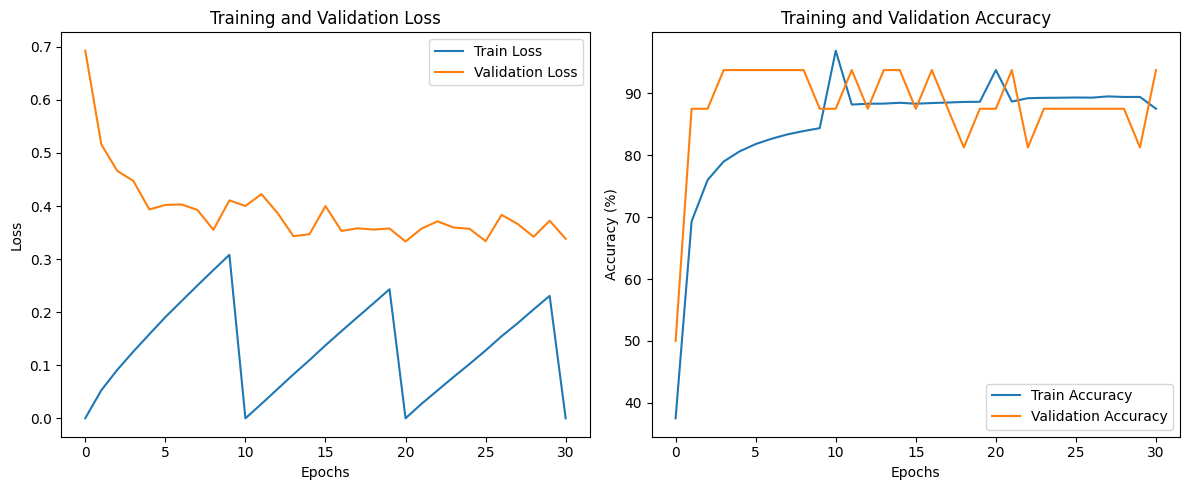

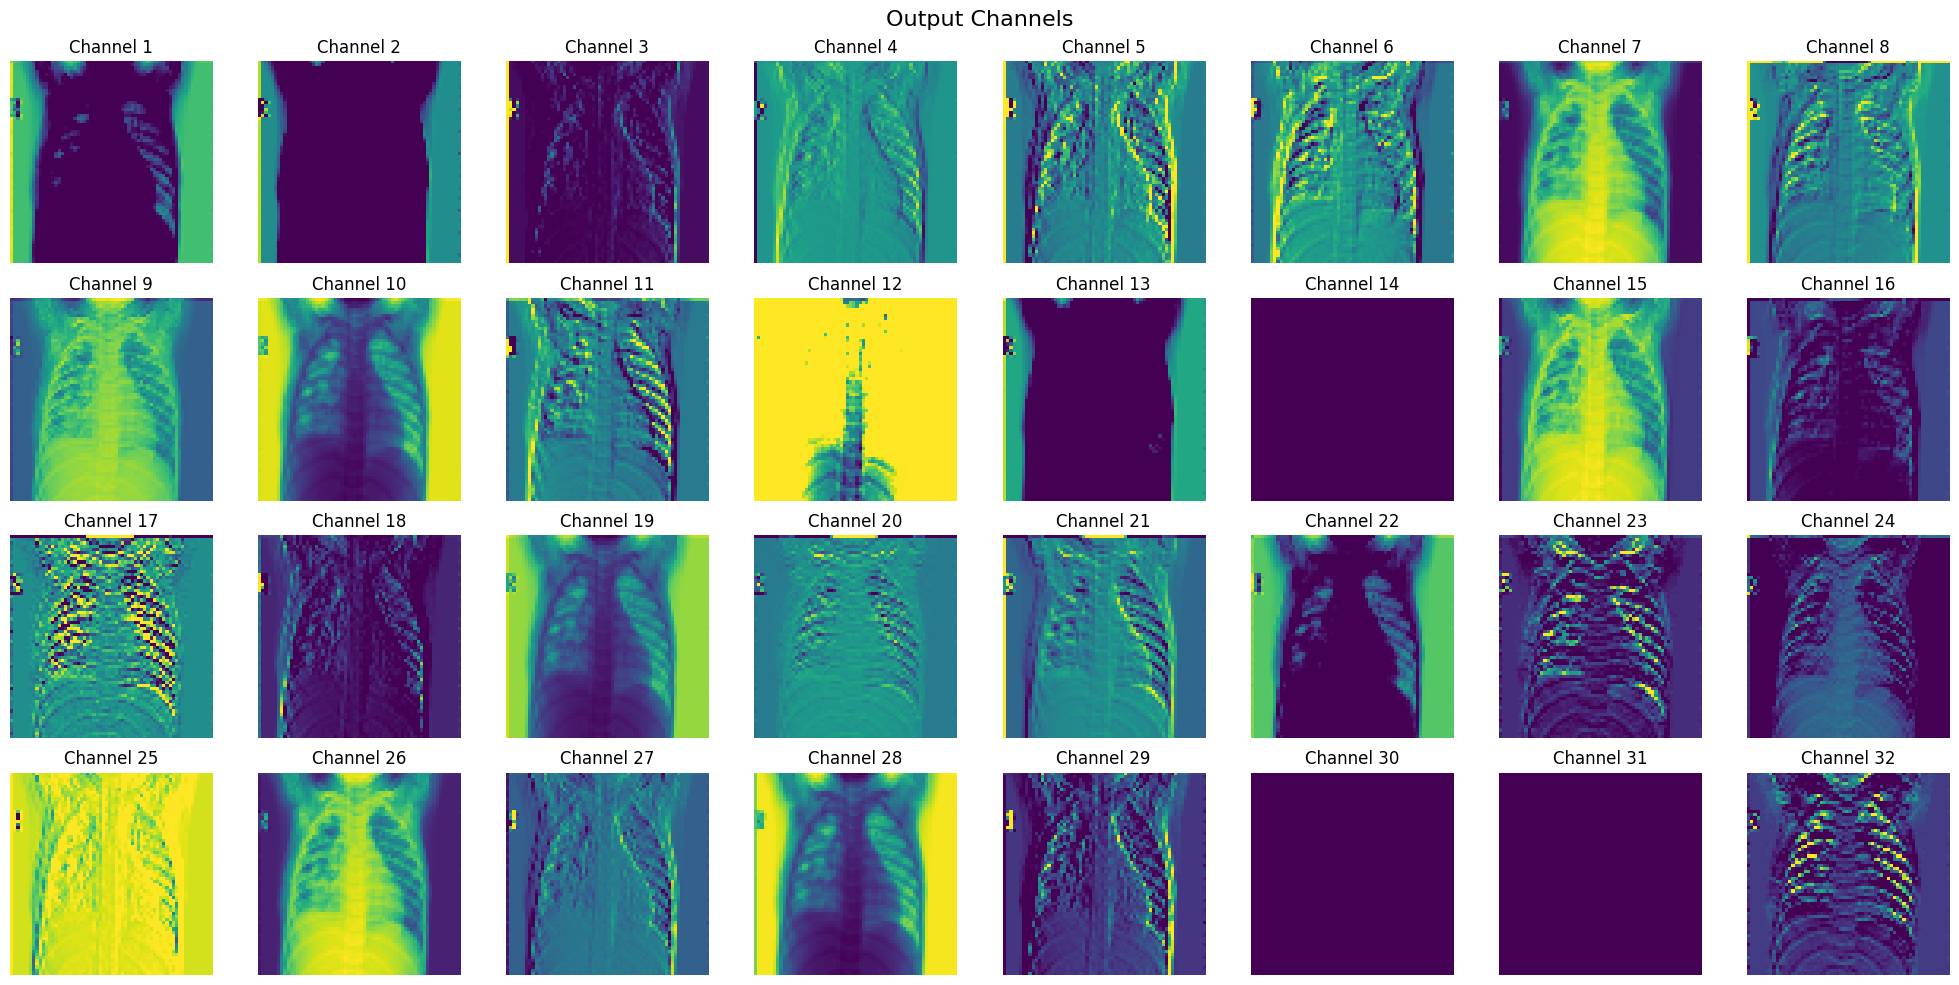

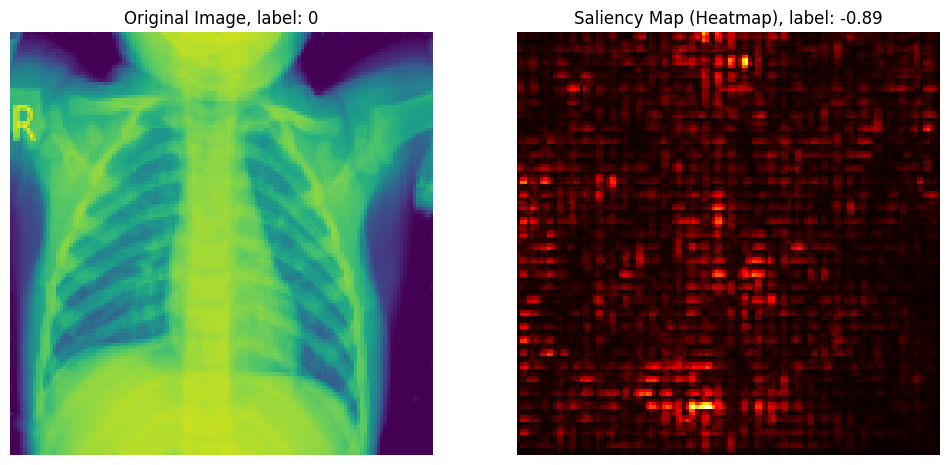

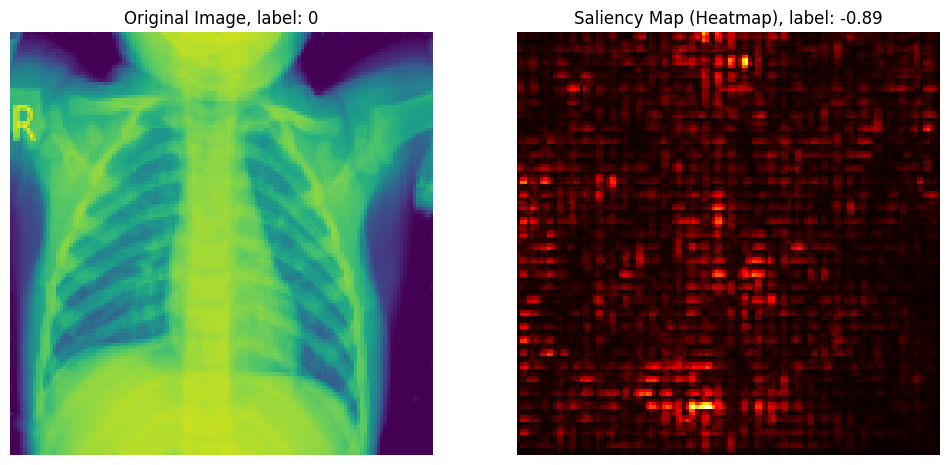

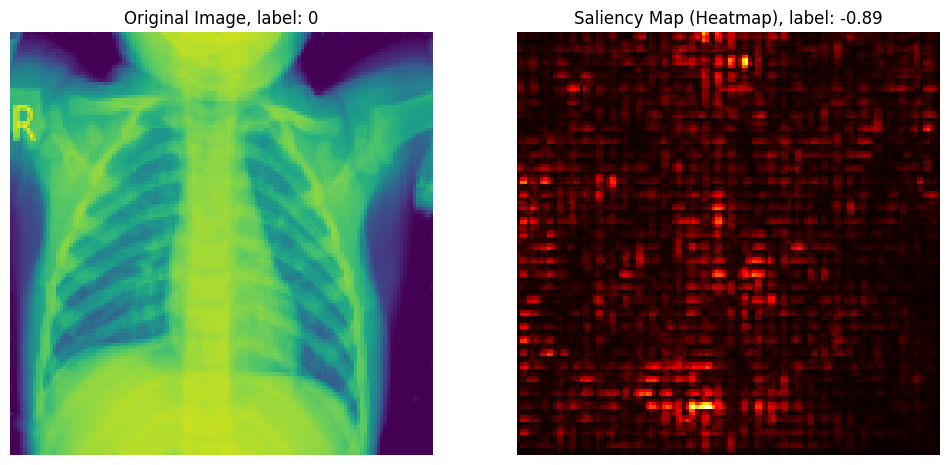

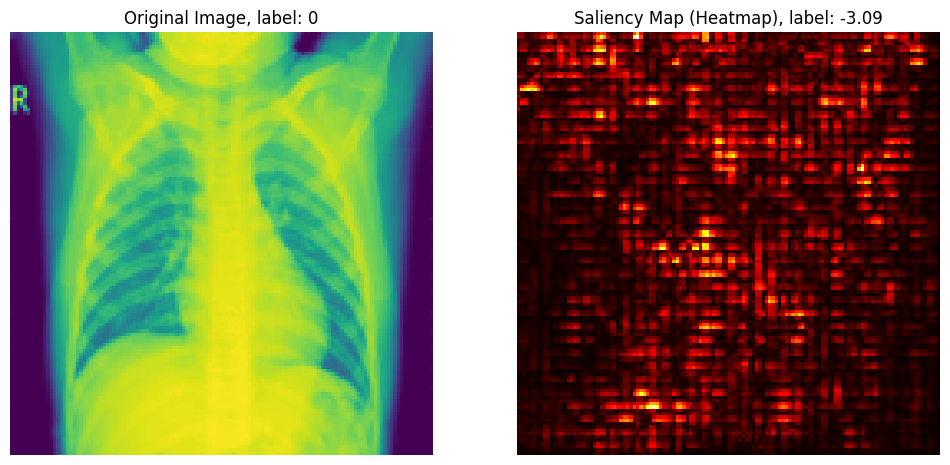

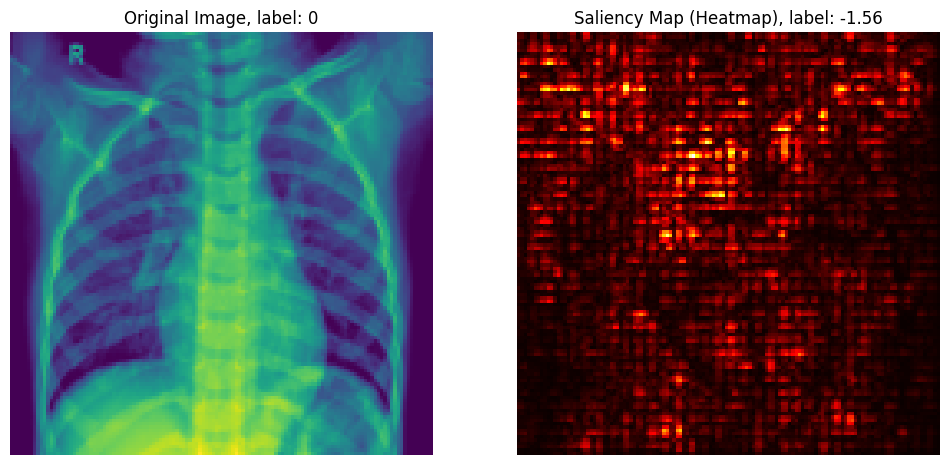

In [28]:
plot_history(history)
plot_first_layer(model.features[0], val_loader)
for _ in range(5):
    plot_heat_map(model, val_loader)

### Tuning

In [29]:
params = [
    ['mobilenet_v2', 'resnet18'],
    [0.2, 0.4],
    [128, 256]
]

In [30]:
all_models = []

for p in product(*params):
    if p[0] == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)
    elif p[0] == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model = create_transfer_learning_model(model, dropout=p[1], last_layer_size=p[2]).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    _ = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=1)
    
    all_models.append((p[0], p[1], p[2], model))

Epoch [0/100],   Train Loss: 0.0004,   Train Accuracy: 37.50%,        Val Loss: 0.6895,   Val Accuracy: 50.00%
Epoch [1/100],   Train Loss: 0.0543,   Train Accuracy: 67.11%,        Val Loss: 0.5070,   Val Accuracy: 75.00%
Epoch [2/100],   Train Loss: 0.0919,   Train Accuracy: 75.18%,        Val Loss: 0.4213,   Val Accuracy: 87.50%
Epoch [3/100],   Train Loss: 0.1254,   Train Accuracy: 78.61%,        Val Loss: 0.3609,   Val Accuracy: 93.75%
Epoch [4/100],   Train Loss: 0.1569,   Train Accuracy: 80.62%,        Val Loss: 0.4009,   Val Accuracy: 93.75%
Early stopping
Best Validation Accuracy: 93.75%
Best Validation Loss: 0.3609
Epoch [0/100],   Train Loss: 0.0004,   Train Accuracy: 37.50%,        Val Loss: 0.6832,   Val Accuracy: 50.00%
Epoch [1/100],   Train Loss: 0.0507,   Train Accuracy: 70.39%,        Val Loss: 0.4941,   Val Accuracy: 87.50%
Epoch [2/100],   Train Loss: 0.0852,   Train Accuracy: 78.02%,        Val Loss: 0.4204,   Val Accuracy: 87.50%
Epoch [3/100],   Train Loss: 0.1179

In [31]:
df = pd.DataFrame(all_models, columns=['model_name', 'dropout', 'last_layer_size', 'model'])
df['train_loss'] = 0.0
df['train_accuracy'] = 0.0
df['val_loss'] = 0.0
df['val_accuracy'] = 0.0
df['name'] = df.apply(lambda x: f"{x['model_name']} {x['dropout']} {x['last_layer_size']}", axis=1)

# tval_loader = DataLoader(datasets.ImageFolder(root='chest_xray/train', transform=data_transform), batch_size=32, shuffle=True, num_workers=4)
for i, (model_name, dropout, last_layer_size, model) in enumerate(all_models):
    train_loss, train_acuracy = validate_model(model, criterion, train_loader)
    val_loss, val_accuracy = validate_model(model, criterion, val_loader)
    df.at[i, 'train_loss'] = train_loss
    df.at[i, 'train_accuracy'] = train_acuracy
    df.at[i, 'val_loss'] = val_loss
    df.at[i, 'val_accuracy'] = val_accuracy
    print(f"Model: {model_name}, Dropout: {dropout}, Last Layer Size: {last_layer_size}, ")

df

/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()


Model: mobilenet_v2, Dropout: 0.2, Last Layer Size: 128, 


/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()
/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()


Model: mobilenet_v2, Dropout: 0.2, Last Layer Size: 256, 


/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()
/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()


Model: mobilenet_v2, Dropout: 0.4, Last Layer Size: 128, 


/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()
/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()


Model: mobilenet_v2, Dropout: 0.4, Last Layer Size: 256, 


/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()
/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()


Model: resnet18, Dropout: 0.2, Last Layer Size: 128, 


/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()
/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()


Model: resnet18, Dropout: 0.2, Last Layer Size: 256, 


/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()
/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()


Model: resnet18, Dropout: 0.4, Last Layer Size: 128, 


/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()
/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()


Model: resnet18, Dropout: 0.4, Last Layer Size: 256, 


/tmp/ipykernel_472770/1323110240.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), tensor(labels).to(device).float()


model_name  dropout  last_layer_size  \
0  mobilenet_v2      0.2              128   
1  mobilenet_v2      0.2              256   
2  mobilenet_v2      0.4              128   
3  mobilenet_v2      0.4              256   
4      resnet18      0.2              128   
5      resnet18      0.2              256   
6      resnet18      0.4              128   
7      resnet18      0.4              256   

                                               model  train_loss  \
0  MobileNetV2(\n  (features): Sequential(\n    (...    0.291173   
1  MobileNetV2(\n  (features): Sequential(\n    (...    0.258511   
2  MobileNetV2(\n  (features): Sequential(\n    (...    0.314121   
3  MobileNetV2(\n  (features): Sequential(\n    (...    0.271478   
4  ResNet(\n  (conv1): Conv2d(3, 64, kernel_size=...    0.334800   
5  ResNet(\n  (conv1): Conv2d(3, 64, kernel_size=...    0.346883   
6  ResNet(\n  (conv1): Conv2d(3, 64, kernel_size=...    0.405271   
7  ResNet(\n  (conv1): Conv2d(3, 64, kernel_size=...    0.340378   

   train_accuracy  val_loss  val_accuracy                  name  
0       87.395111  0.353438         87.50  mobilenet_v2 0.2 128  
1       89.037034  0.344099         81.25  mobilenet_v2 0.2 256  
2       87.522188  0.377716         87.50  mobilenet_v2 0.4 128  
3       89.293206  0.320417         93.75  mobilenet_v2 0.4 256  
4       86.301840  0.492777         68.75      resnet18 0.2 128  
5       85.827820  0.469119         75.00      resnet18 0.2 256  
6       81.319590  0.525773         68.75      resnet18 0.4 128  
7       86.533807  0.442158         87.50      resnet18 0.4 256

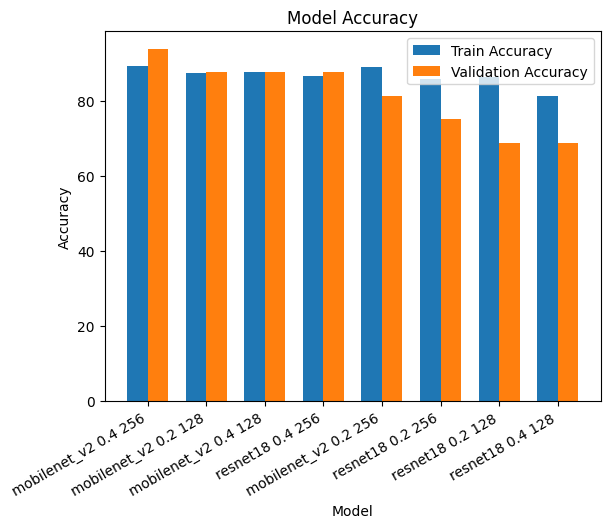

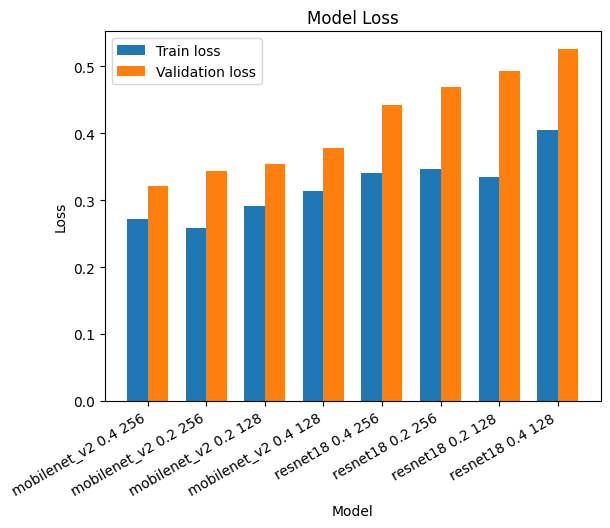

In [32]:
df = df.sort_values(by='val_accuracy', ascending=False)

x = np.arange(len(df['model']))
width = 0.35

plt.bar(x - width/2, df['train_accuracy'], width, label='Train Accuracy')
plt.bar(x + width/2, df['val_accuracy'], width, label='Validation Accuracy')

plt.xticks(x, df['name'], rotation=30, ha='right')
plt.legend()
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()


df = df.sort_values(by='val_loss', ascending=True)

x = np.arange(len(df['model']))
width = 0.35

plt.bar(x - width/2, df['train_loss'], width, label='Train loss')
plt.bar(x + width/2, df['val_loss'], width, label='Validation loss')

plt.xticks(x, df['name'], rotation=30, ha='right')
plt.legend()
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

# Training with tuning pretrained model

### model

In [33]:
model = create_transfer_learning_model(models.mobilenet_v2(
    weights=models.MobileNet_V2_Weights.IMAGENET1K_V2), dropout=0.4, last_layer_size=256).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### training 1

In [40]:
history = train_model(model, criterion, optimizer, train_loader,
                      val_loader, device, num_epochs=10, patience=10)

Epoch [0/100],   Train Loss: 0.0002,   Train Accuracy: 87.50%,        Val Loss: 0.4099,   Val Accuracy: 87.50%
Epoch [1/100],   Train Loss: 0.0248,   Train Accuracy: 89.56%,        Val Loss: 0.4021,   Val Accuracy: 87.50%
Epoch [2/100],   Train Loss: 0.0506,   Train Accuracy: 89.25%,        Val Loss: 0.3189,   Val Accuracy: 87.50%
Epoch [3/100],   Train Loss: 0.0747,   Train Accuracy: 89.40%,        Val Loss: 0.2888,   Val Accuracy: 93.75%
Epoch [4/100],   Train Loss: 0.0992,   Train Accuracy: 89.38%,        Val Loss: 0.3460,   Val Accuracy: 87.50%
Epoch [5/100],   Train Loss: 0.1235,   Train Accuracy: 89.46%,        Val Loss: 0.3681,   Val Accuracy: 81.25%
Epoch [6/100],   Train Loss: 0.1494,   Train Accuracy: 89.52%,        Val Loss: 0.3242,   Val Accuracy: 87.50%
Epoch [7/100],   Train Loss: 0.1741,   Train Accuracy: 89.55%,        Val Loss: 0.4130,   Val Accuracy: 81.25%
Epoch [8/100],   Train Loss: 0.1987,   Train Accuracy: 89.58%,        Val Loss: 0.3766,   Val Accuracy: 87.50%
E

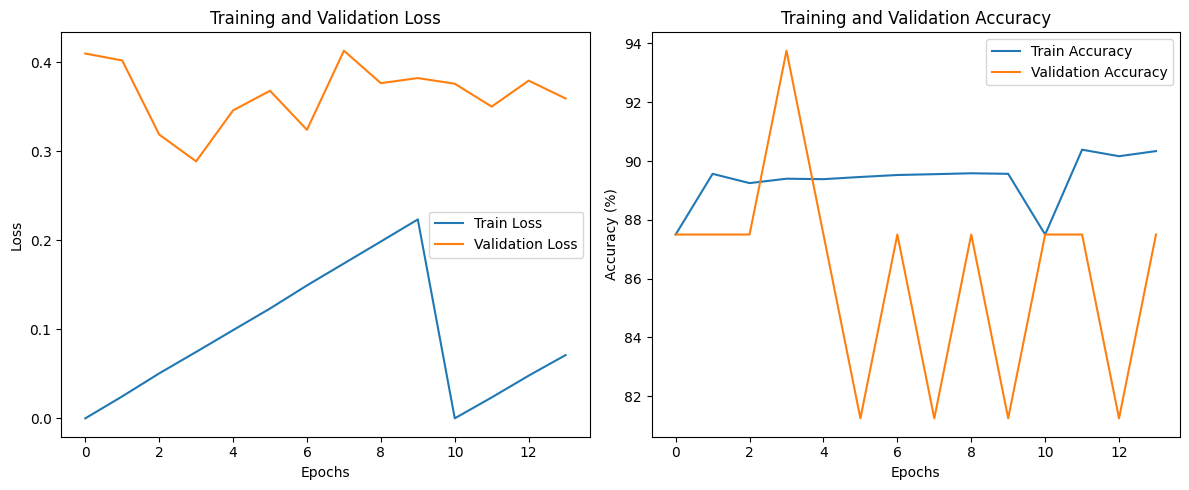

In [41]:
plot_history(history)

### training 2 with last mobilenet layer

In [42]:
model.features[-1].requires_grad = True

In [43]:
history = train_model(model, criterion, optimizer, train_loader,
                      val_loader, device, num_epochs=10, patience=10)

Epoch [0/100],   Train Loss: 0.0001,   Train Accuracy: 100.00%,        Val Loss: 0.3390,   Val Accuracy: 87.50%
Epoch [1/100],   Train Loss: 0.0236,   Train Accuracy: 89.72%,        Val Loss: 0.3616,   Val Accuracy: 87.50%
Epoch [2/100],   Train Loss: 0.0478,   Train Accuracy: 89.98%,        Val Loss: 0.4128,   Val Accuracy: 81.25%
Epoch [3/100],   Train Loss: 0.0724,   Train Accuracy: 89.88%,        Val Loss: 0.3585,   Val Accuracy: 87.50%
Epoch [4/100],   Train Loss: 0.0952,   Train Accuracy: 90.08%,        Val Loss: 0.3480,   Val Accuracy: 87.50%
Epoch [5/100],   Train Loss: 0.1203,   Train Accuracy: 89.92%,        Val Loss: 0.3436,   Val Accuracy: 87.50%
Epoch [6/100],   Train Loss: 0.1445,   Train Accuracy: 89.96%,        Val Loss: 0.3148,   Val Accuracy: 87.50%
Epoch [7/100],   Train Loss: 0.1668,   Train Accuracy: 90.05%,        Val Loss: 0.3894,   Val Accuracy: 87.50%
Epoch [8/100],   Train Loss: 0.1909,   Train Accuracy: 90.04%,        Val Loss: 0.3712,   Val Accuracy: 87.50%


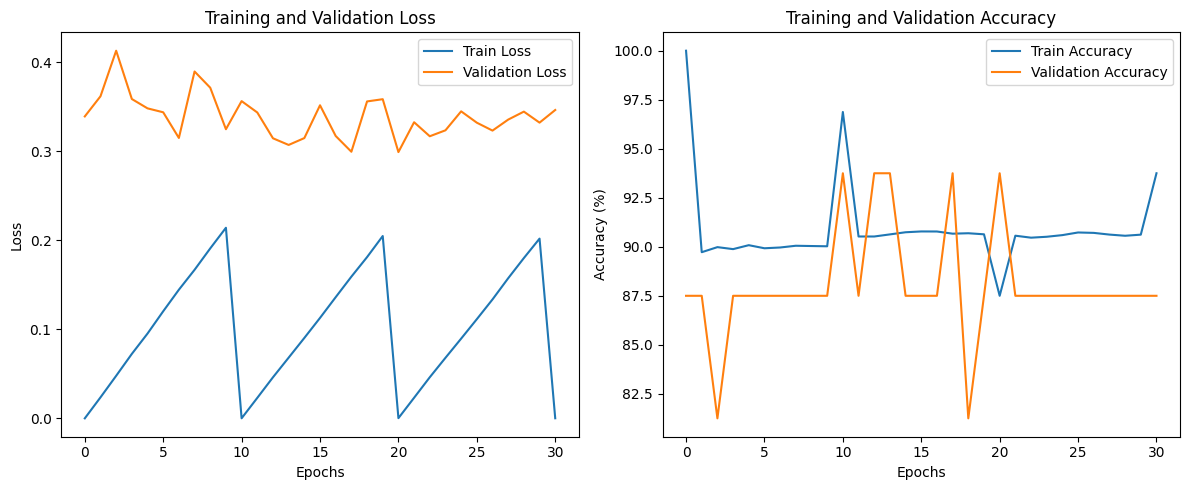

In [44]:
plot_history(history)

### Visualisations

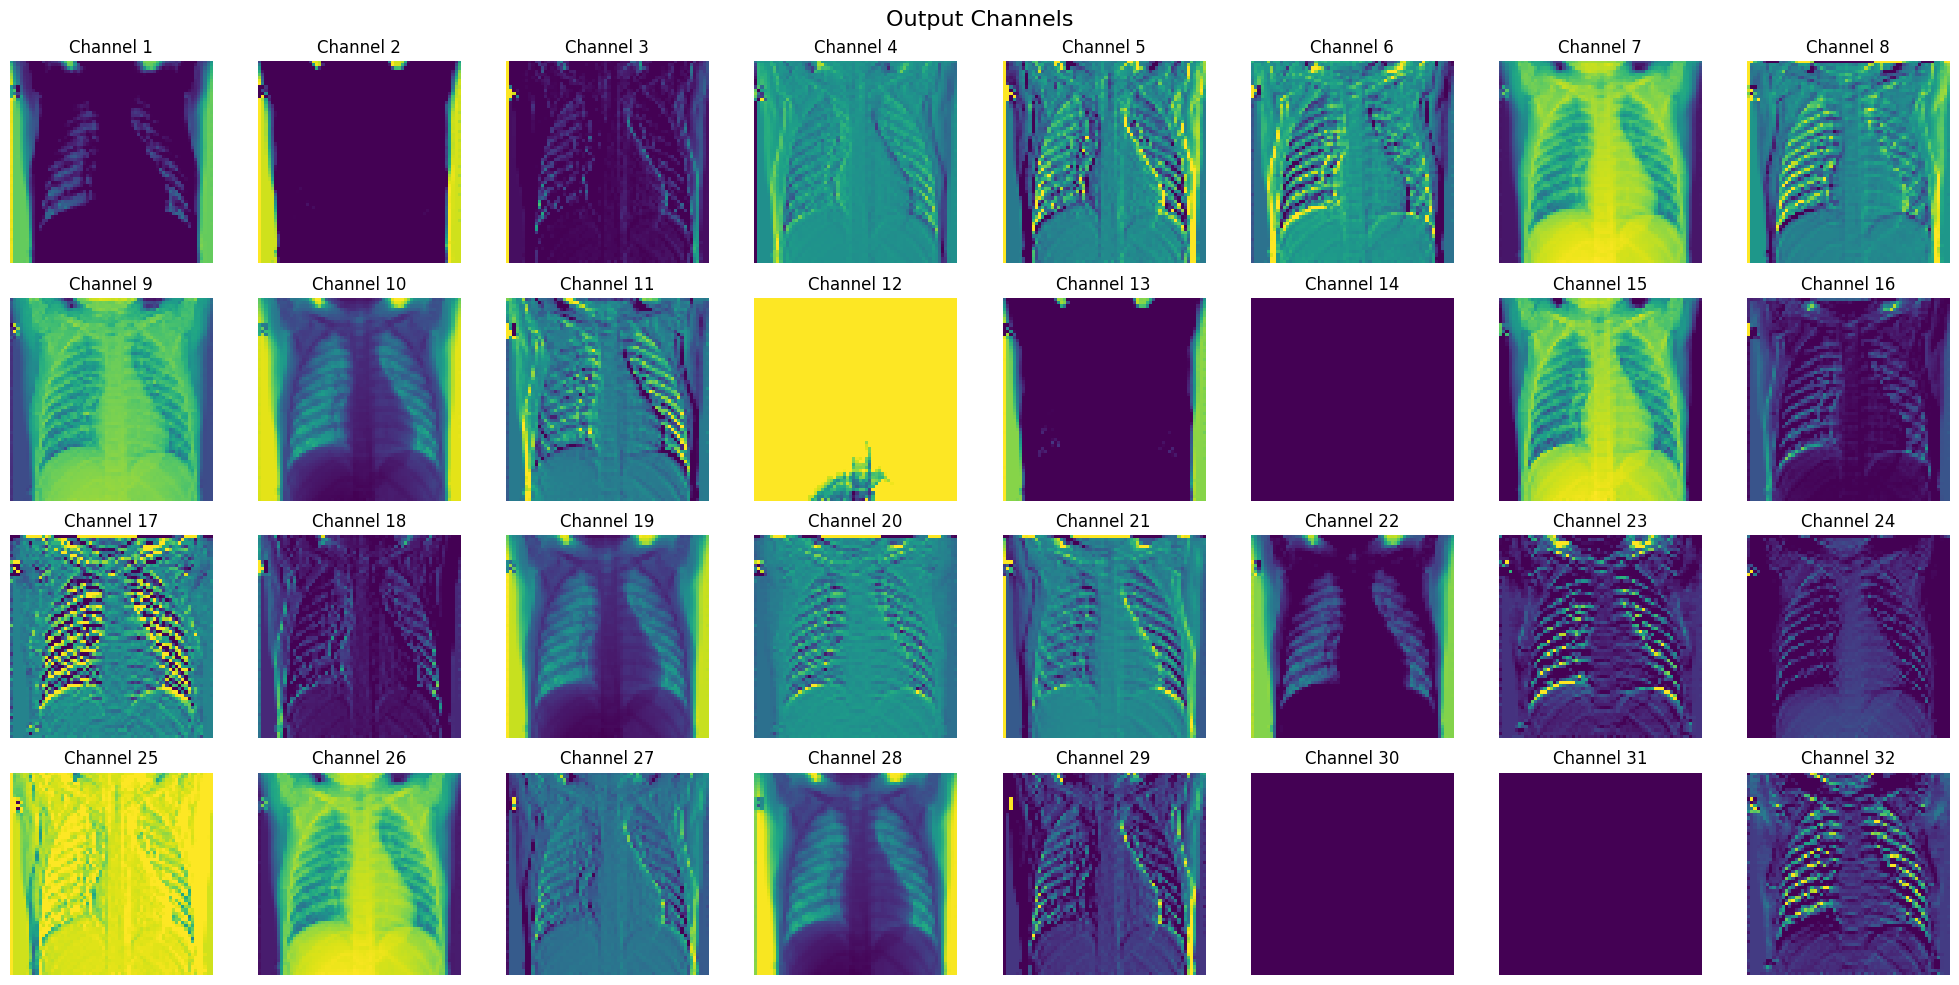

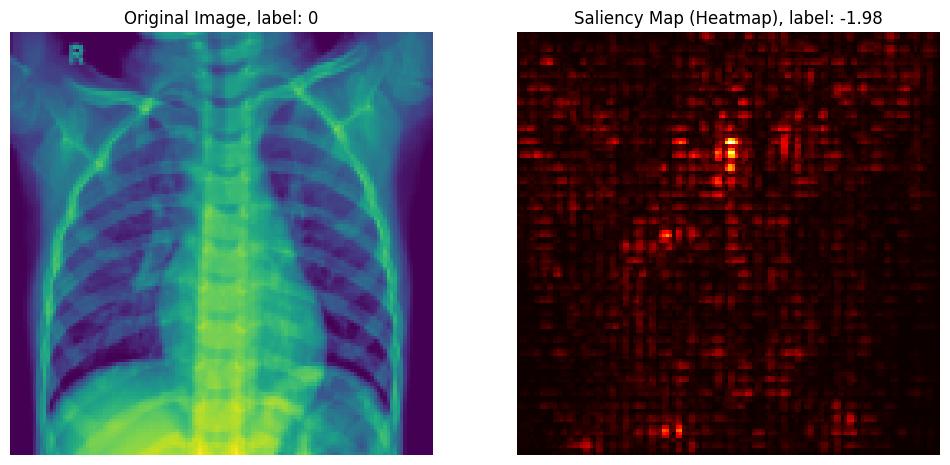

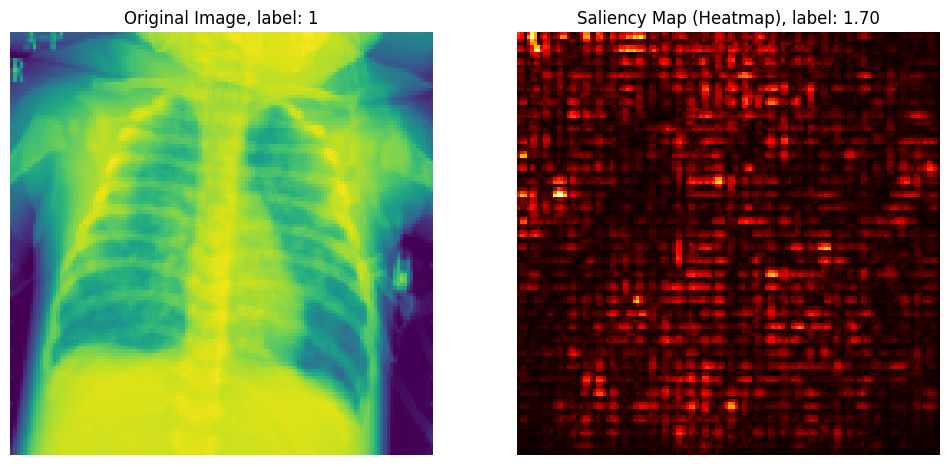

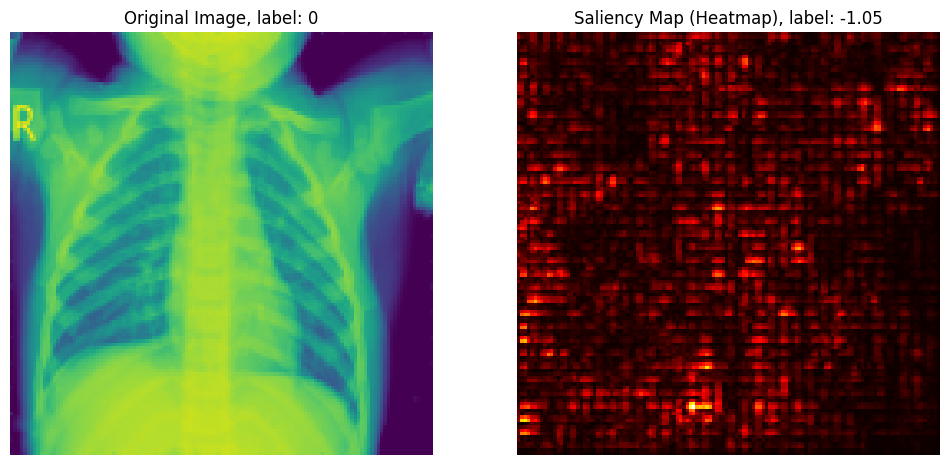

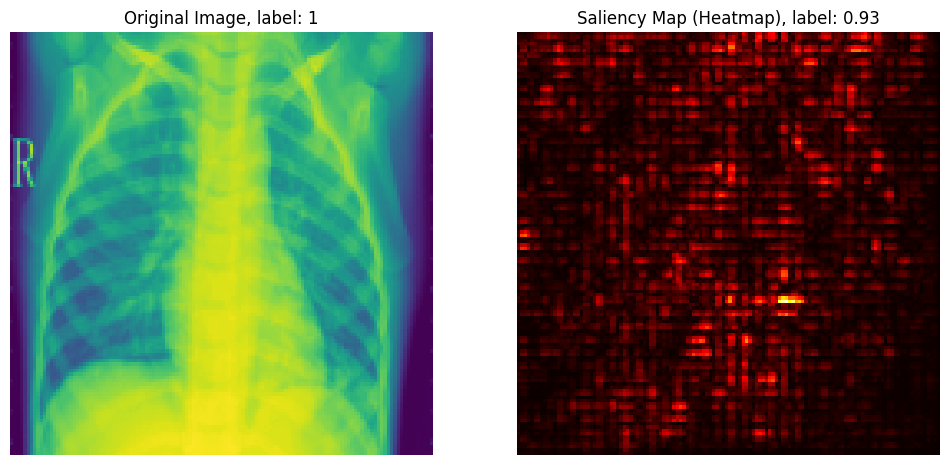

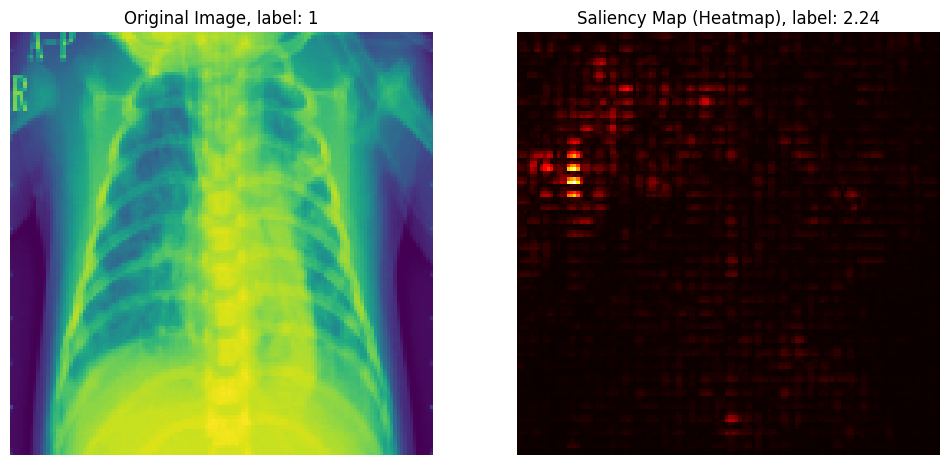

In [45]:
plot_first_layer(model.features[0], val_loader)
for _ in range(5):
    plot_heat_map(model, val_loader)

# Conclusions

W tym projekcie próbowałem stworzyć model CNN będący w stanie rozpoznawać zapalenie płuc na podstawie zdjęcia rentgenowskiego. 

Nauczyłem się że:
- Augumentacja zbioru potrafi być bardzo czasochłonna, warto raz wygenerować augumentowane dane i potem nie tracić czasu podczas dopracowywania modelu
- Wygląda na to że rozkład pikseli na które zwraca uwagę mobilenet mają wzór siatki, co zapewne jest spowodowane stride-em w warstwach CNN
- W przypadku obrazów łatwo o overfitting, warto używać wysokiego dropout-u, augumentacji.
- Przyglądając się pierwszej warstwie CNN można zobaczyć że niektóre kanały się nie trenują, albo zwracają uwagę na otoczenie zamiast na widoczny obiekt
- Mały zbiór walidacyjny może nie reprezentować dokładnie precyzji modelu. Nie rozszerzyłem go o część danych treningowych bo obawiałem się że mogą one być już augumentowane.

Podejścia:
- Na początku stworzyłem własną sieć CNN i próbowałem ją dopracować
- Później wykorzystywałem pretrenowane modele
- Wyświetlałem obraz po pierwszej warstwie oraz mapę ciepła pikseli na które model zwraca uwagę.
- Sprawdziłem różne hiperparametry i modele by znaleźć najlepszy
- Pod koniec włączyłem trening ostatniej warstwy CNN pretrenowanego modelu by zwiększyć dokładność.